In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from einops import rearrange, repeat
from transformers import CLIPImageProcessor, CLIPTextModel, CLIPTokenizer, CLIPVisionModelWithProjection

import sys
sys.path.append('/home/wxd/video-generation/diffusers/src')

from diffusers.models.unet_action_v03 import UNetSpatioTemporalConditionModel_Action
from diffusers import AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers import ActionVideoDiffusionPipeline

In [2]:
pretrained_model_name_or_path = '/ssd_datasets/wxiaodong/ckpt/drive-video-s256-v02-ep100'
text_encoder = CLIPTextModel.from_pretrained(
            pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
            pretrained_model_name_or_path, subfolder="vae"
)

text_encoder.eval()
vae.eval()
text_encoder.to('cuda:1')
vae.to('cuda:1')

tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer")
scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
feature_extractor = CLIPImageProcessor.from_pretrained(pretrained_model_name_or_path, subfolder="feature_extractor")

In [3]:
# The U-Net Path
unet = UNetSpatioTemporalConditionModel_Action.from_pretrained('/ssd_datasets/wxiaodong/ckpt/textaction-v03-ep100', subfolder="unet")
unet.eval()
unet = unet.to('cuda:1')

add image context parameters
add image context parameters
add image context parameters
add image context parameters
add image context parameters


In [4]:
pipeline = ActionVideoDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=unet,
            scheduler=scheduler,
            tokenizer=tokenizer,
            feature_extractor=feature_extractor
)
pipeline.to('cuda:1')

ActionVideoDiffusionPipeline {
  "_class_name": "ActionVideoDiffusionPipeline",
  "_diffusers_version": "0.25.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNetSpatioTemporalConditionModel_Action"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
### test examples
import os
files = os.listdir('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames')

In [6]:
from transformers import AutoProcessor, AutoModelForCausalLM
git_processor_large = AutoProcessor.from_pretrained("/ssd_datasets/wxiaodong/ckpt/git-large-coco")
git_model_large = AutoModelForCausalLM.from_pretrained("/ssd_datasets/wxiaodong/ckpt/git-large-coco")

In [8]:
git_model_large.to('cuda:1')
def generate_caption(image):
    pil_list = [image.convert('RGB')]
    inputs = git_processor_large(images=pil_list, return_tensors="pt").to('cuda:1')
    
    generated_ids = git_model_large.generate(pixel_values=inputs.pixel_values, max_length=50)

    generated_caption = git_processor_large.batch_decode(generated_ids, skip_special_tokens=True)
   
    return generated_caption[0]

In [42]:
import json
json_path = '/ssd_datasets/wxiaodong/nuscene/frame_action_train.json'
with open(json_path, 'r') as f:
    frame_action = json.load(f)

In [43]:
# plot steer
# training set
all_steers = []
all_speeds = []
for k in frame_action.keys():
    all_steers.extend(frame_action[k][0])
    all_speeds.extend(frame_action[k][1])
len(all_steers)

27005

min: 5.019918720396163, max: 177.05702308947718


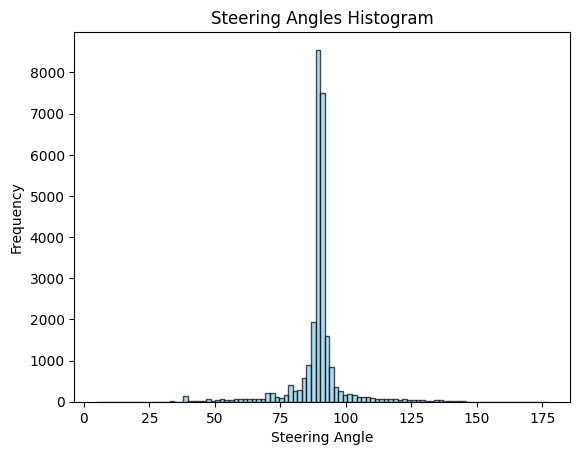

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# 假设steering_angles是你的转向值数组
steering_angles = np.array(all_steers) * np.pi / 180 * 10 + 90  # 替换为你的实际数据

# 获取最大和最小值
min_value = np.min(steering_angles)
max_value = np.max(steering_angles)
print(f'min: {min_value}, max: {max_value}')

# 设置直方图的边界
bin_edges = np.linspace(min_value, max_value, 100)  # 在这个例子中，分成20个区间

# 绘制直方图
plt.hist(steering_angles, bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.title('Steering Angles Histogram')
plt.xlabel('Steering Angle')
plt.ylabel('Frequency')

# 显示图形
plt.show()


min: 2.0, max: 183.63888888888889


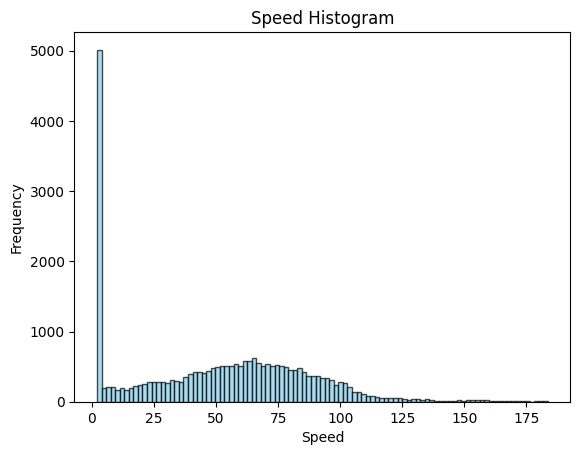

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# 假设steering_angles是你的转向值数组
steering_angles = np.array(all_speeds) * 10. / 36 * 10 + 2  # 替换为你的实际数据

# 获取最大和最小值
min_value = np.min(steering_angles)
max_value = np.max(steering_angles)

print(f'min: {min_value}, max: {max_value}')

# 设置直方图的边界
bin_edges = np.linspace(min_value, max_value, 100)  # 在这个例子中，分成20个区间

# 绘制直方图
plt.hist(steering_angles, bins=bin_edges, color='skyblue', edgecolor='black', alpha=0.7)

# 添加标题和标签
plt.title('Speed Histogram')
plt.xlabel('Speed')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [38]:
steers = torch.tensor(100) * np.pi / 180 * 1
speeds = torch.tensor(30) * 10. / 36 * 1
print(steers, speeds)

tensor(1.7453) tensor(8.3333)


In [66]:
def _get_add_time_ids(
        batch_size,
        fps=2,
        motion_bucket_id=127,
        noise_aug_strength=0.,
        num_videos_per_prompt=1,
        do_classifier_free_guidance=False,
    ):
        add_time_ids = [fps, motion_bucket_id, noise_aug_strength]

        passed_add_embed_dim = 256 * len(add_time_ids)
        expected_add_embed_dim = 768

        if expected_add_embed_dim != passed_add_embed_dim:
            raise ValueError(
                f"Model expects an added time embedding vector of length {expected_add_embed_dim}, but a vector of {passed_add_embed_dim} was created. The model has an incorrect config. Please check `unet.config.time_embedding_type` and `text_encoder_2.config.projection_dim`."
            )

        add_time_ids = torch.tensor([add_time_ids])
        add_time_ids = add_time_ids.repeat(batch_size * num_videos_per_prompt, 1)

        if do_classifier_free_guidance:
            add_time_ids = torch.cat([add_time_ids, add_time_ids])

        return add_time_ids

In [80]:
from diffusers.models.embeddings import TimestepEmbedding, Timesteps
add_time_proj = Timesteps(256, True, downscale_freq_shift=0)
add_embedding = TimestepEmbedding(768, 1280)
added_time_ids = _get_add_time_ids(8) # (8, 3)
added_time_ids.shape

torch.Size([8, 3])

In [78]:
batch_size = 8
time_embeds = add_time_proj(added_time_ids.flatten())
time_embeds = time_embeds.reshape((batch_size, -1))
time_embeds.shape

torch.Size([8, 768])

In [74]:
aug_emb = add_embedding(time_embeds)
aug_emb.shape

torch.Size([8, 1280])

n008-2018-08-22-15-53-49-0400__CAM_FRONT__1534967928412404.jpg
a person walking across a street in front of a building.
torch.Size([8, 1])


/tmp/ipykernel_30450/2681549500.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  steers = torch.tensor(steers) * np.pi / 180 * action_scale


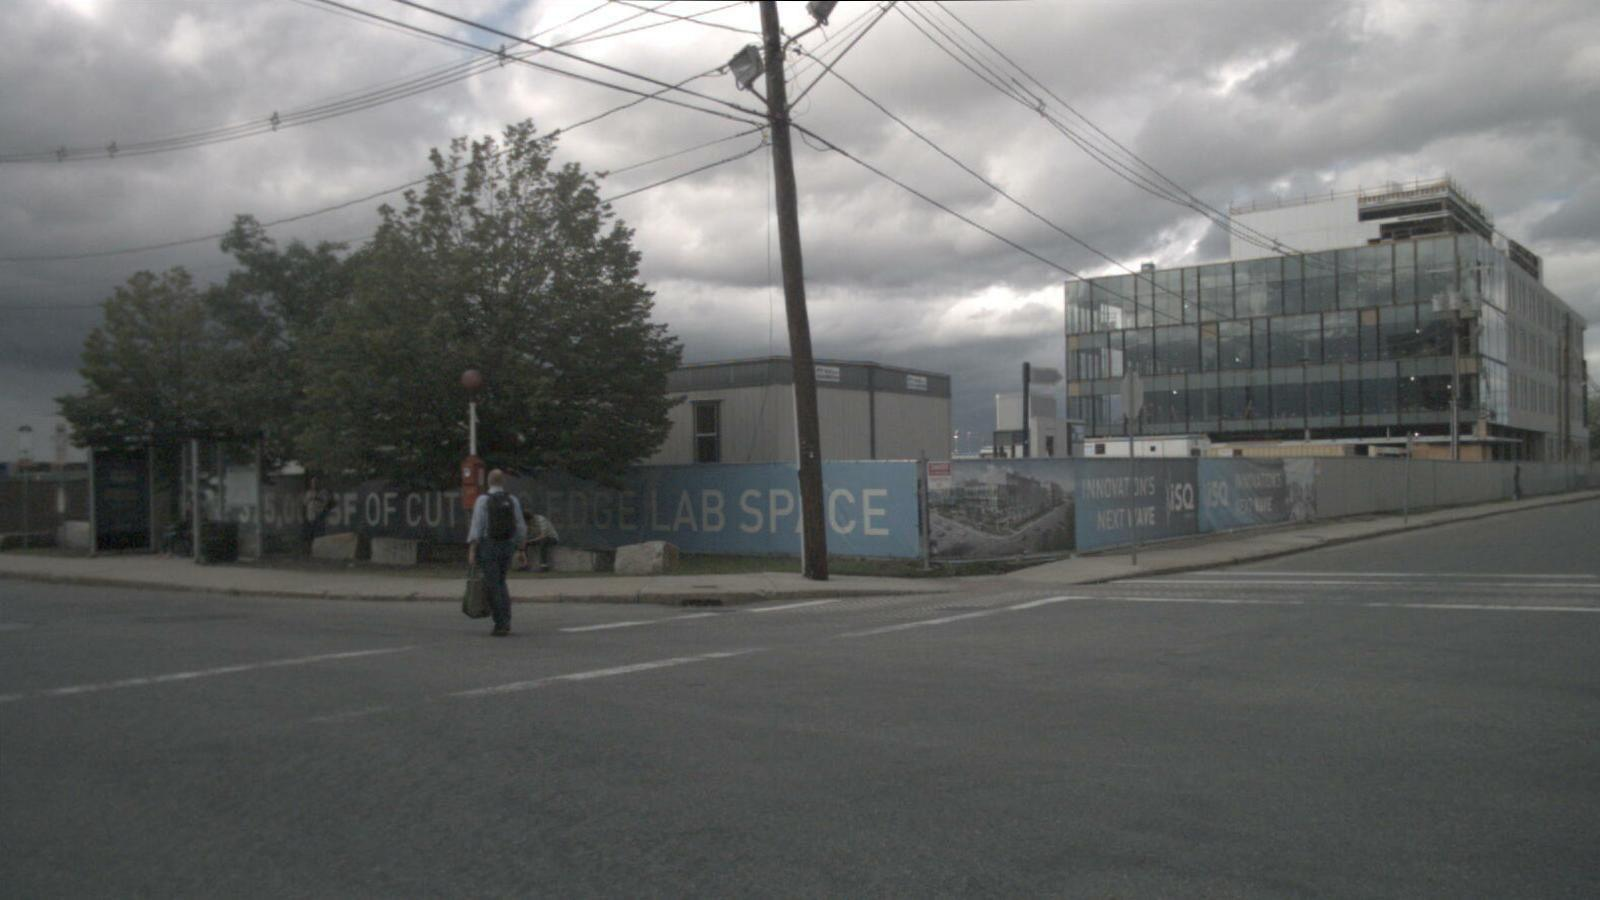

In [38]:
from PIL import Image
import numpy as np

file_idx = 11
image_path = os.path.join('/ssd_datasets/wxiaodong/ckpt/Val_samples/val_first_frames', files[file_idx])
print(files[file_idx])
image = Image.open(image_path)
prompt = generate_caption(image)
# prompt = "some cars are driving on a street surrounded by trees."
print(prompt)

action_scale = 1
# steers = [[17.59999999999991,
#  14.299999999999727,
#  14.299999999999727,
#  14.299999999999727,
#  16.799999999999727,
#  18.0,
#  19.699999999999818,
#  23.0]]
speeds = [[22.17,
 21.29,
 20.38,
 19.48,
 19.03,
 19.150000000000002,
 19.740000000000002,
 20.59]]
steers = torch.ones((8, 1)) * -100
# steers = torch.zeros((8, 1))
# speeds = torch.zeros((8, 1))
         
steers = torch.tensor(steers) * np.pi / 180 * action_scale
speeds = torch.tensor(speeds) * 10. / 36 * action_scale
print(steers.shape)

steers = steers.view(-1, 1)
speeds = speeds.view(-1, 1)
action = torch.cat([steers, speeds], dim=-1)
action = action.to('cuda:1')
image

In [39]:
# negative -> right turn, positive -> left turn
frames = pipeline(image,num_frames=8, prompt=prompt, action=action, height=256, width=512).frames[0]

text emb shape:  torch.Size([1, 77, 768])


  0%|          | 0/25 [00:00<?, ?it/s]

In [40]:
#save first 8 frames
frames[0] = image.resize((512, 256)).convert('RGB')
frames[0]
# default saving method in diffusers
from diffusers.utils import export_to_video
export_to_video(frames, f"val_{file_idx}_s256_8f_action_v03_right_turn.mp4", fps=6)

'val_11_s256_8f_action_v03_right_turn.mp4'